In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors

from multiprocessing import cpu_count
from multiprocessing import Pool


3778
51519.293494715705


(array([2712.,  312.,  211.,  129.,  134.,  103.,   63.,   43.,   44.,
          27.]),
 array([5.15192935e+04, 1.39574865e+08, 2.79098210e+08, 4.18621555e+08,
        5.58144901e+08, 6.97668246e+08, 8.37191591e+08, 9.76714937e+08,
        1.11623828e+09, 1.25576163e+09, 1.39528497e+09]),
 <BarContainer object of 10 artists>)

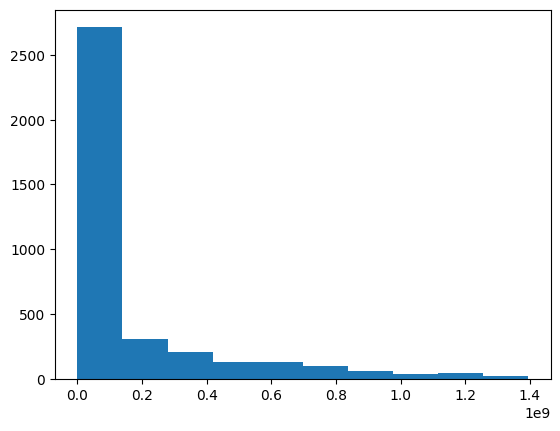

In [15]:
data = pd.read_parquet('/export/data/vgiusepp/data/full_dataframe/dataframe/dataframe.parquet')
data['star_log10mass'] = 10**data['star_log10mass']
data_mass = data['star_log10mass'].drop_duplicates()
data_mass = data_mass[data_mass<1.4*1e9]
print(len(data_mass))
print(data_mass.min())
plt.hist(data_mass)

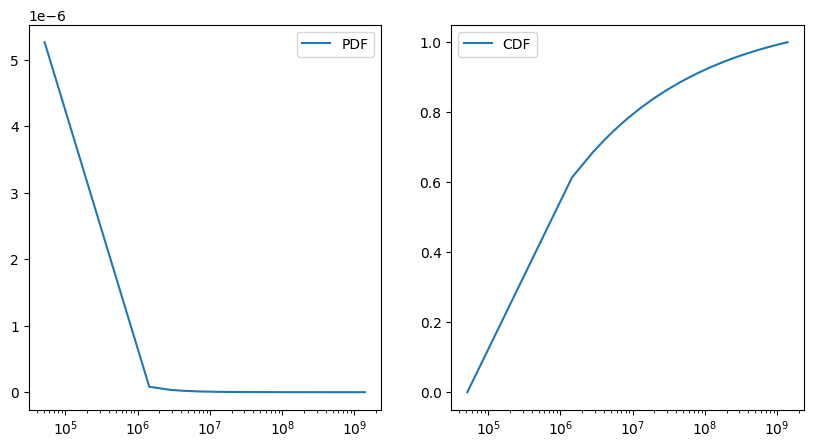

In [16]:
m_min, m_max = data_mass.min(), data_mass.max()
alpha = 1.25
def pdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* m**(-alpha)
def cdf(m, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (1/norm_const)* (1/(1-alpha)) * (m**(1-alpha) - m_min**(1-alpha))

mass =  np.linspace(m_min, m_max, 1000 )
fig =  plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(mass, pdf(mass, alpha), label='PDF')
ax.set_xscale('log')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(mass, cdf(mass, alpha), label='CDF')
ax.set_xscale('log')
ax.legend()

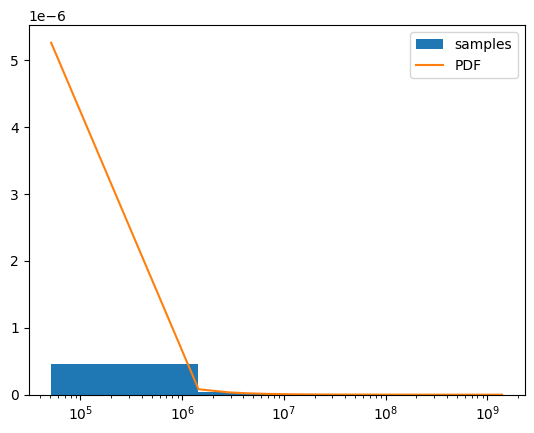

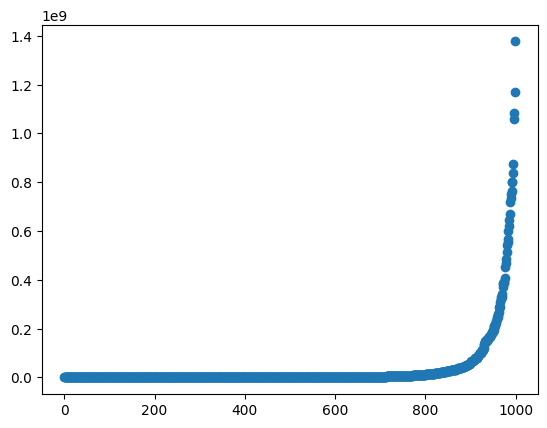

In [17]:
def inverse_cdf(y, alpha):
    norm_const = (m_max**(1-alpha) - m_min**(1-alpha))/(1-alpha) 
    return (y*norm_const*(1-alpha) + m_min**(1-alpha))**(1/(1-alpha))

samples = inverse_cdf(np.random.rand(1_000), alpha, )
plt.hist(samples, density=True, bins=1000, label='samples')
plt.plot(mass, pdf(mass, alpha), label='PDF',)
plt.xscale('log')
plt.legend()
plt.show()

plt.scatter(range(samples.shape[0]), sorted(samples))


In [59]:
import numpy as np

# Assuming mass_series is your series of mass values
mass_nn = data_mass.values.reshape(-1, 1)

x = samples.reshape(-1, 1)  # The values for which you want to find the nearest neighbors

# Number of neighbors you want to find
N = 2

# Create a NearestNeighbors object
nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)

# Find the N nearest neighbors of x
distances, indices = nbrs.kneighbors(x)

# # Print the nearest neighbors for each value in x
# for i, value in enumerate(x.flatten()):
#     print(f"The {N} nearest neighbors of {value} are: {mass_nn[indices[i]].flatten()}")

In [60]:
sim_mass = [mass_nn[indices[i]][0][0] for i, value in enumerate(x.flatten())]

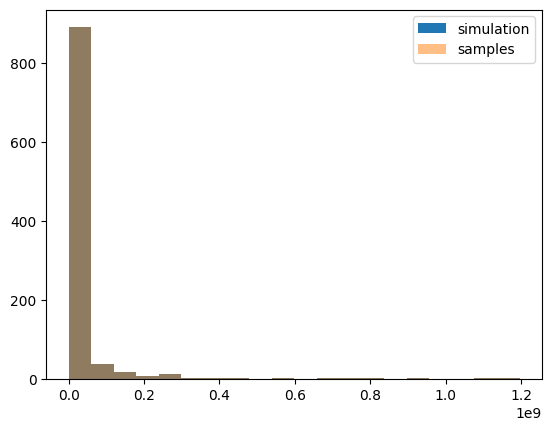

In [61]:
plt.hist(sim_mass, bins=20, label='simulation')
plt.hist(samples, bins=20, alpha=0.5, label='samples')
plt.legend()

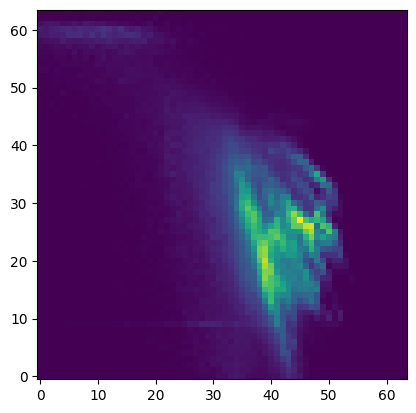

In [62]:
hist = np.sum( np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in sim_mass ]), axis=0)
plt.imshow(hist.T, origin='lower')

In [70]:
def gen_real_halo(j):
    np.random.seed(j)
    samples = inverse_cdf(np.random.rand(100), alpha, )
    # Assuming mass_series is your series of mass values
    mass_nn = data_mass.values.reshape(-1, 1)

    x = samples.reshape(-1, 1)  # The values for which you want to find the nearest neighbors

    # Number of neighbors you want to find
    N = 2

    # Create a NearestNeighbors object
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)

    # Find the N nearest neighbors of x
    distances, indices = nbrs.kneighbors(x)
    sim_mass = [mass_nn[indices[i]][0][0] for i, value in enumerate(x.flatten())]
    
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in sim_mass ])
    hist = np.sum( arr, axis=0)
    return hist, np.sum(np.array(sim_mass))
    

In [71]:
from multiprocessing import Pool

with Pool() as p:
    result = p.map(gen_real_halo, range(50) )

hist_list, sim_mass_list = zip(*result)

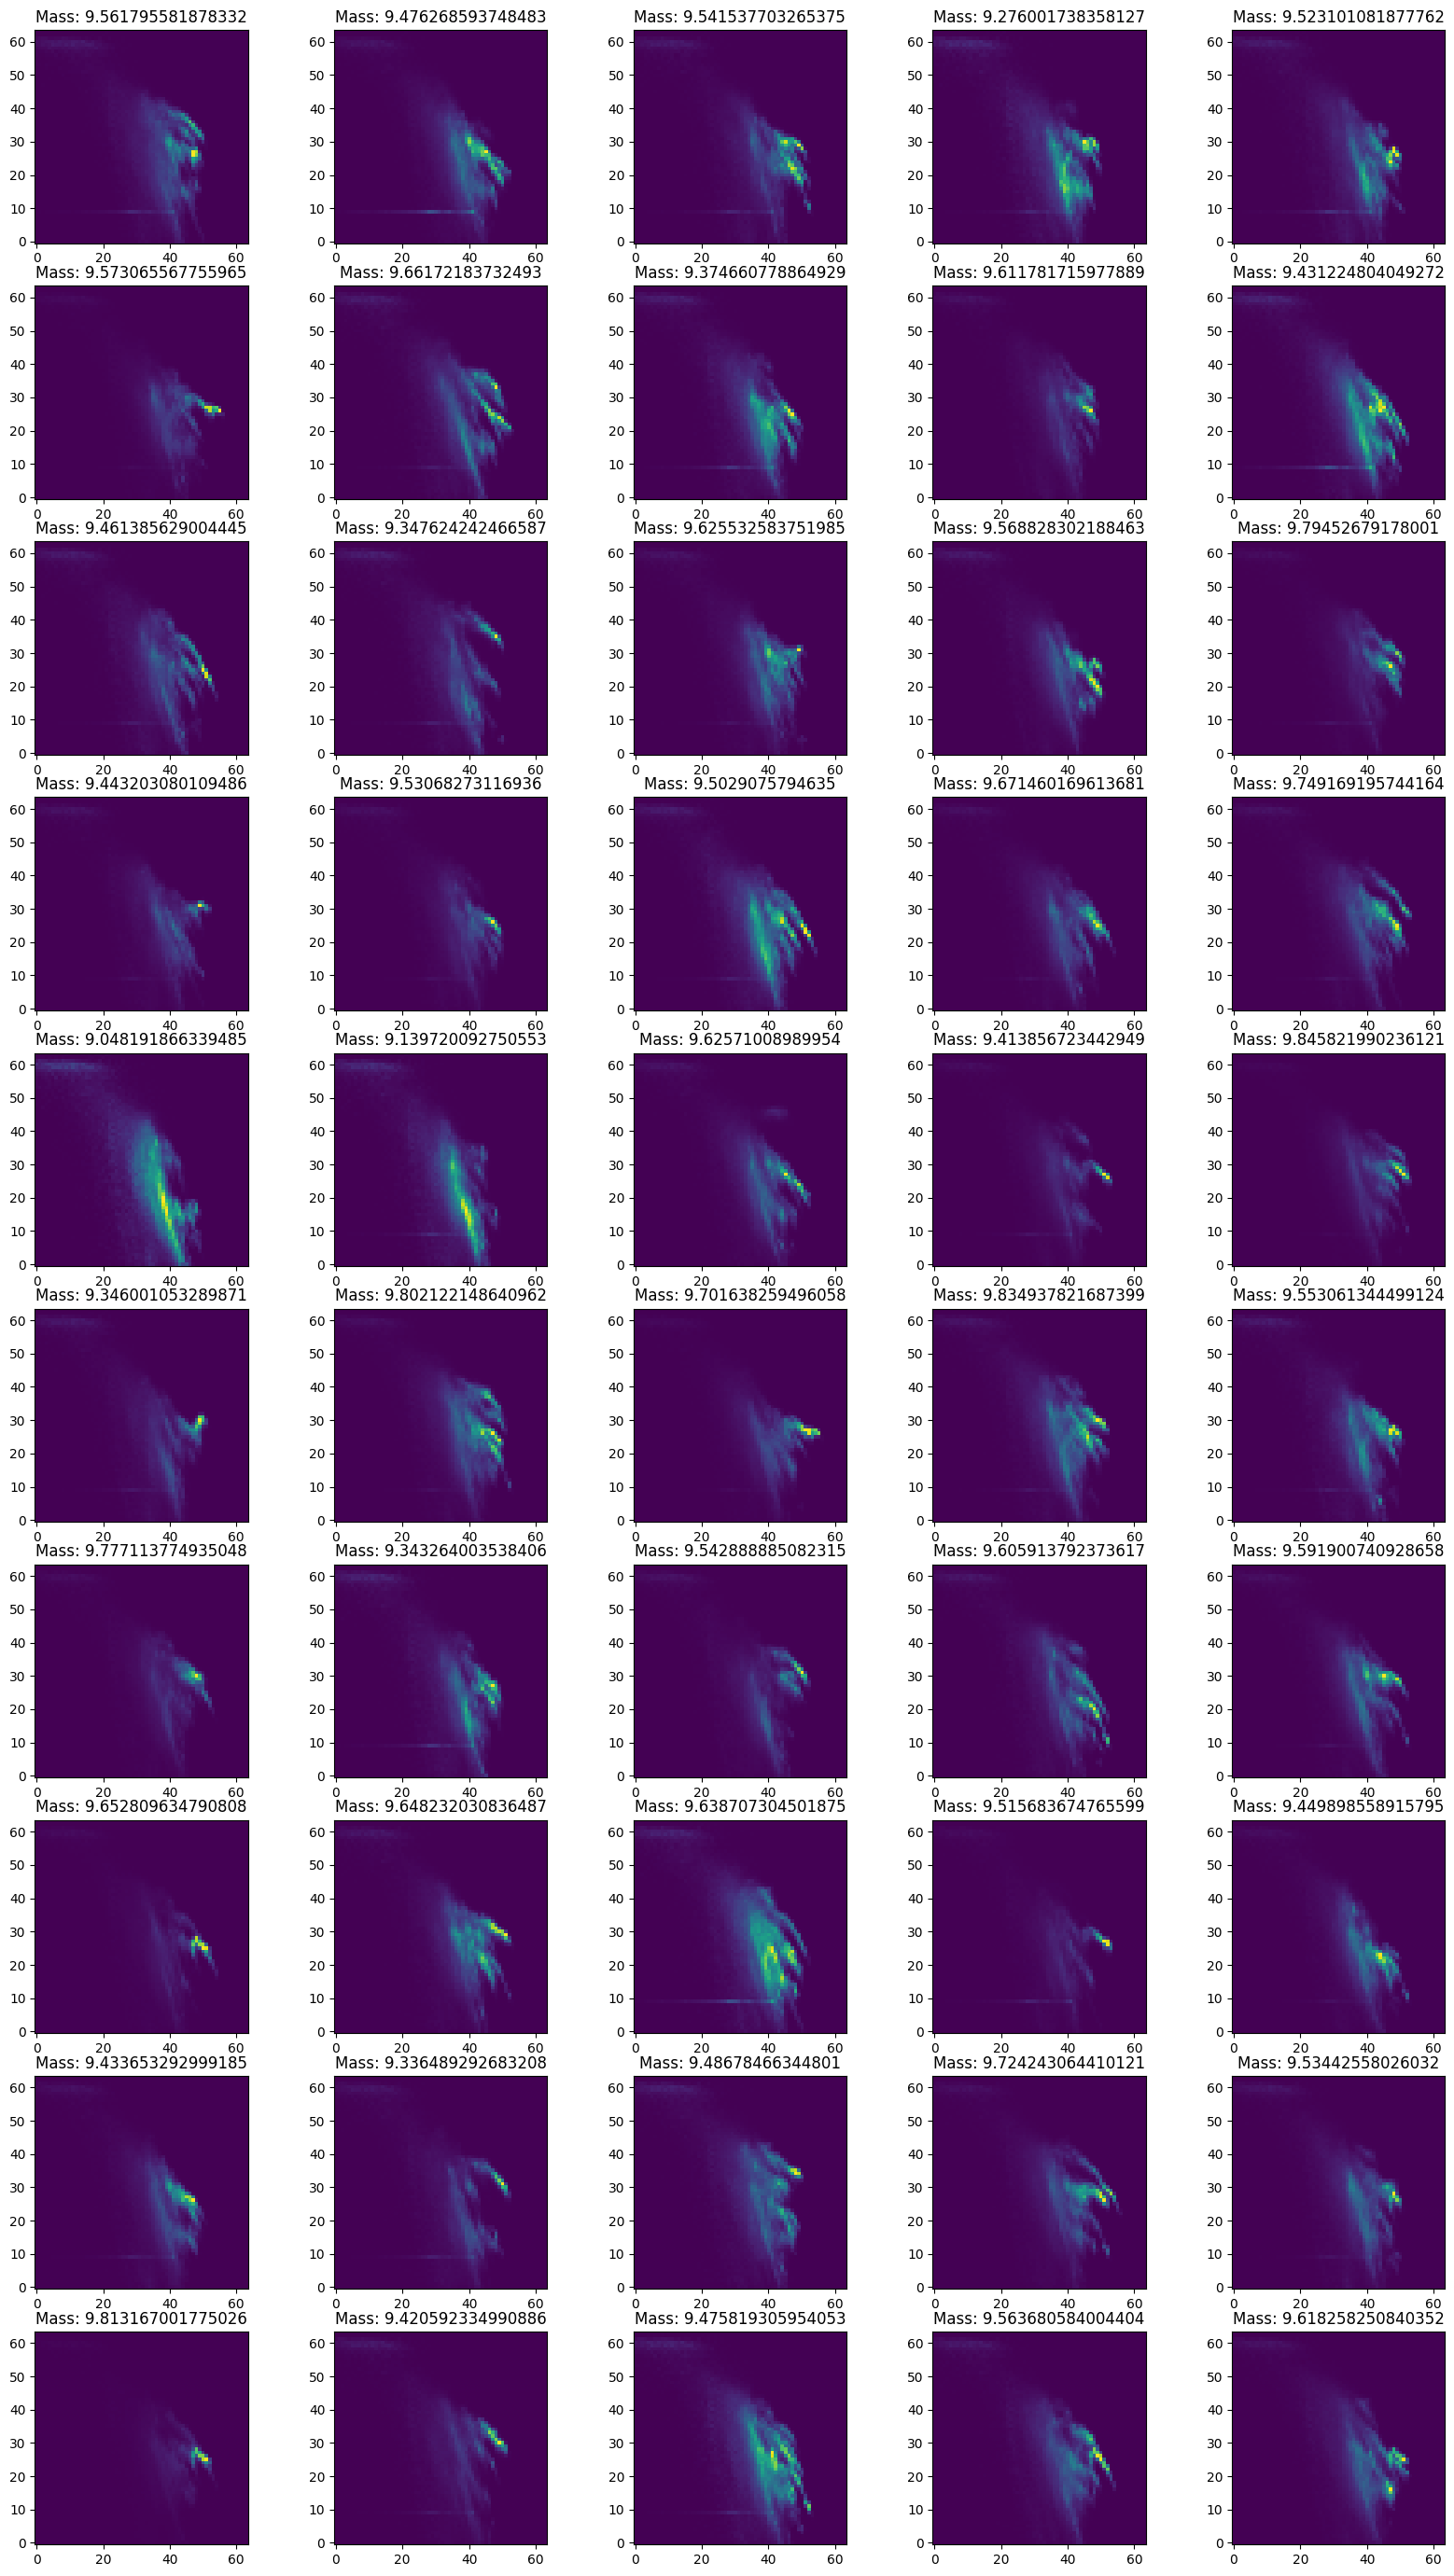

In [73]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(hist.T, origin='lower', )
    ax.set_title(f'Mass: {np.log10(sim_mass_list[i])}')

(array([2., 5., 7., 9., 9., 8., 2., 2., 3., 3.]),
 array([1.11735677e+09, 1.70678894e+09, 2.29622111e+09, 2.88565327e+09,
        3.47508544e+09, 4.06451760e+09, 4.65394977e+09, 5.24338193e+09,
        5.83281410e+09, 6.42224626e+09, 7.01167843e+09]),
 <BarContainer object of 10 artists>)

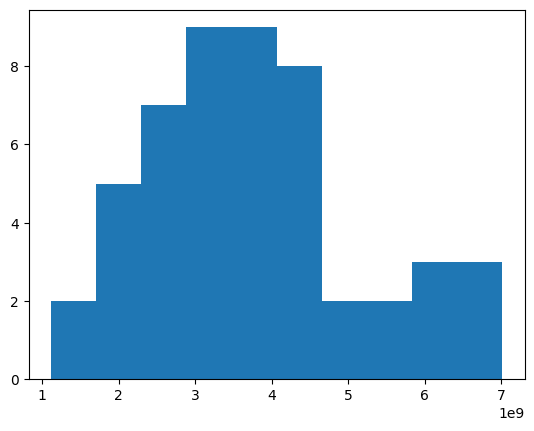

In [74]:
plt.hist(sim_mass_list)

## More realistic halo with a total mass budget and first sample than NN

In [150]:
def gen_real_halo(j):
    np.random.seed(j)
    M_tot = 1.8 * 1e9
    samples = []
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot > data_mass.max():
            samples.append(inverse_cdf(np.random.rand(1), alpha, ))
            M_tot = M_tot - samples[-1]
        else:
            if M_tot < data_mass.min():
                break
            max_u = cdf(M_tot, alpha)
            samples.append(inverse_cdf(np.random.uniform(0, max_u), alpha, ))
            M_tot = M_tot - samples[-1]
        iteration += 1 
        
    # Assuming mass_series is your series of mass values
    mass_nn = data_mass.values.reshape(-1, 1)

    samples =  np.array(samples)
    x = samples.reshape(-1, 1)  # The values for which you want to find the nearest neighbors

    # Number of neighbors you want to find
    N = 2

    # Create a NearestNeighbors object
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)

    # Find the N nearest neighbors of x
    distances, indices = nbrs.kneighbors(x)
    sim_mass = [mass_nn[indices[i]][0][0] for i, value in enumerate(x.flatten())]
    
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in sim_mass ])
    hist = np.sum( arr, axis=0)
    return hist, sim_mass, samples

In [124]:
hist, sim, samples = gen_real_halo(0)

M_tot 1400000000.0
M_tot [1.39913468e+09]
M_tot [1.39530476e+09]
M_tot [1.39398174e+09]
max_u [0.99998025]
M_tot [1.39314142e+09]
max_u [0.9999675]
M_tot [1.39276782e+09]
max_u [0.99996183]
M_tot [1.39084299e+09]
max_u [0.99993258]
M_tot [1.39043619e+09]
max_u [0.99992639]
M_tot [1.3388879e+09]
max_u [0.99912345]
M_tot [1.01421219e+09]
max_u [0.99298194]
M_tot [1.01392167e+09]
max_u [0.99297538]
M_tot [1.00492908e+09]
max_u [0.99277122]
M_tot [1.00420156e+09]
max_u [0.9927546]
M_tot [1.00323129e+09]
max_u [0.99273241]
M_tot [9.08617255e+08]
max_u [0.99043042]
M_tot [9.08549882e+08]
max_u [0.99042867]
M_tot [9.08478102e+08]
max_u [0.99042682]
M_tot [9.08422595e+08]
max_u [0.99042538]
M_tot [8.92799446e+08]
max_u [0.99001631]
M_tot [8.8548159e+08]
max_u [0.98982162]
M_tot [8.56857131e+08]
max_u [0.98904027]
M_tot [4.71885311e+08]
max_u [0.97368087]
M_tot [4.63799831e+08]
max_u [0.97320084]
M_tot [4.63362627e+08]
max_u [0.97317458]
M_tot [4.56969928e+08]
max_u [0.97278712]
M_tot [4.568892

Text(0.5, 1.0, '1.40e+00 1e9')

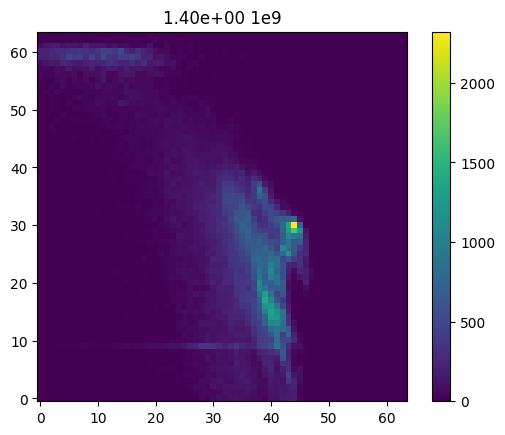

In [126]:
plt.imshow(hist.T, origin='lower')
plt.colorbar()
plt.title(f'{np.sum(sim)/1e9:.2e} 1e9')

### Outlier detection

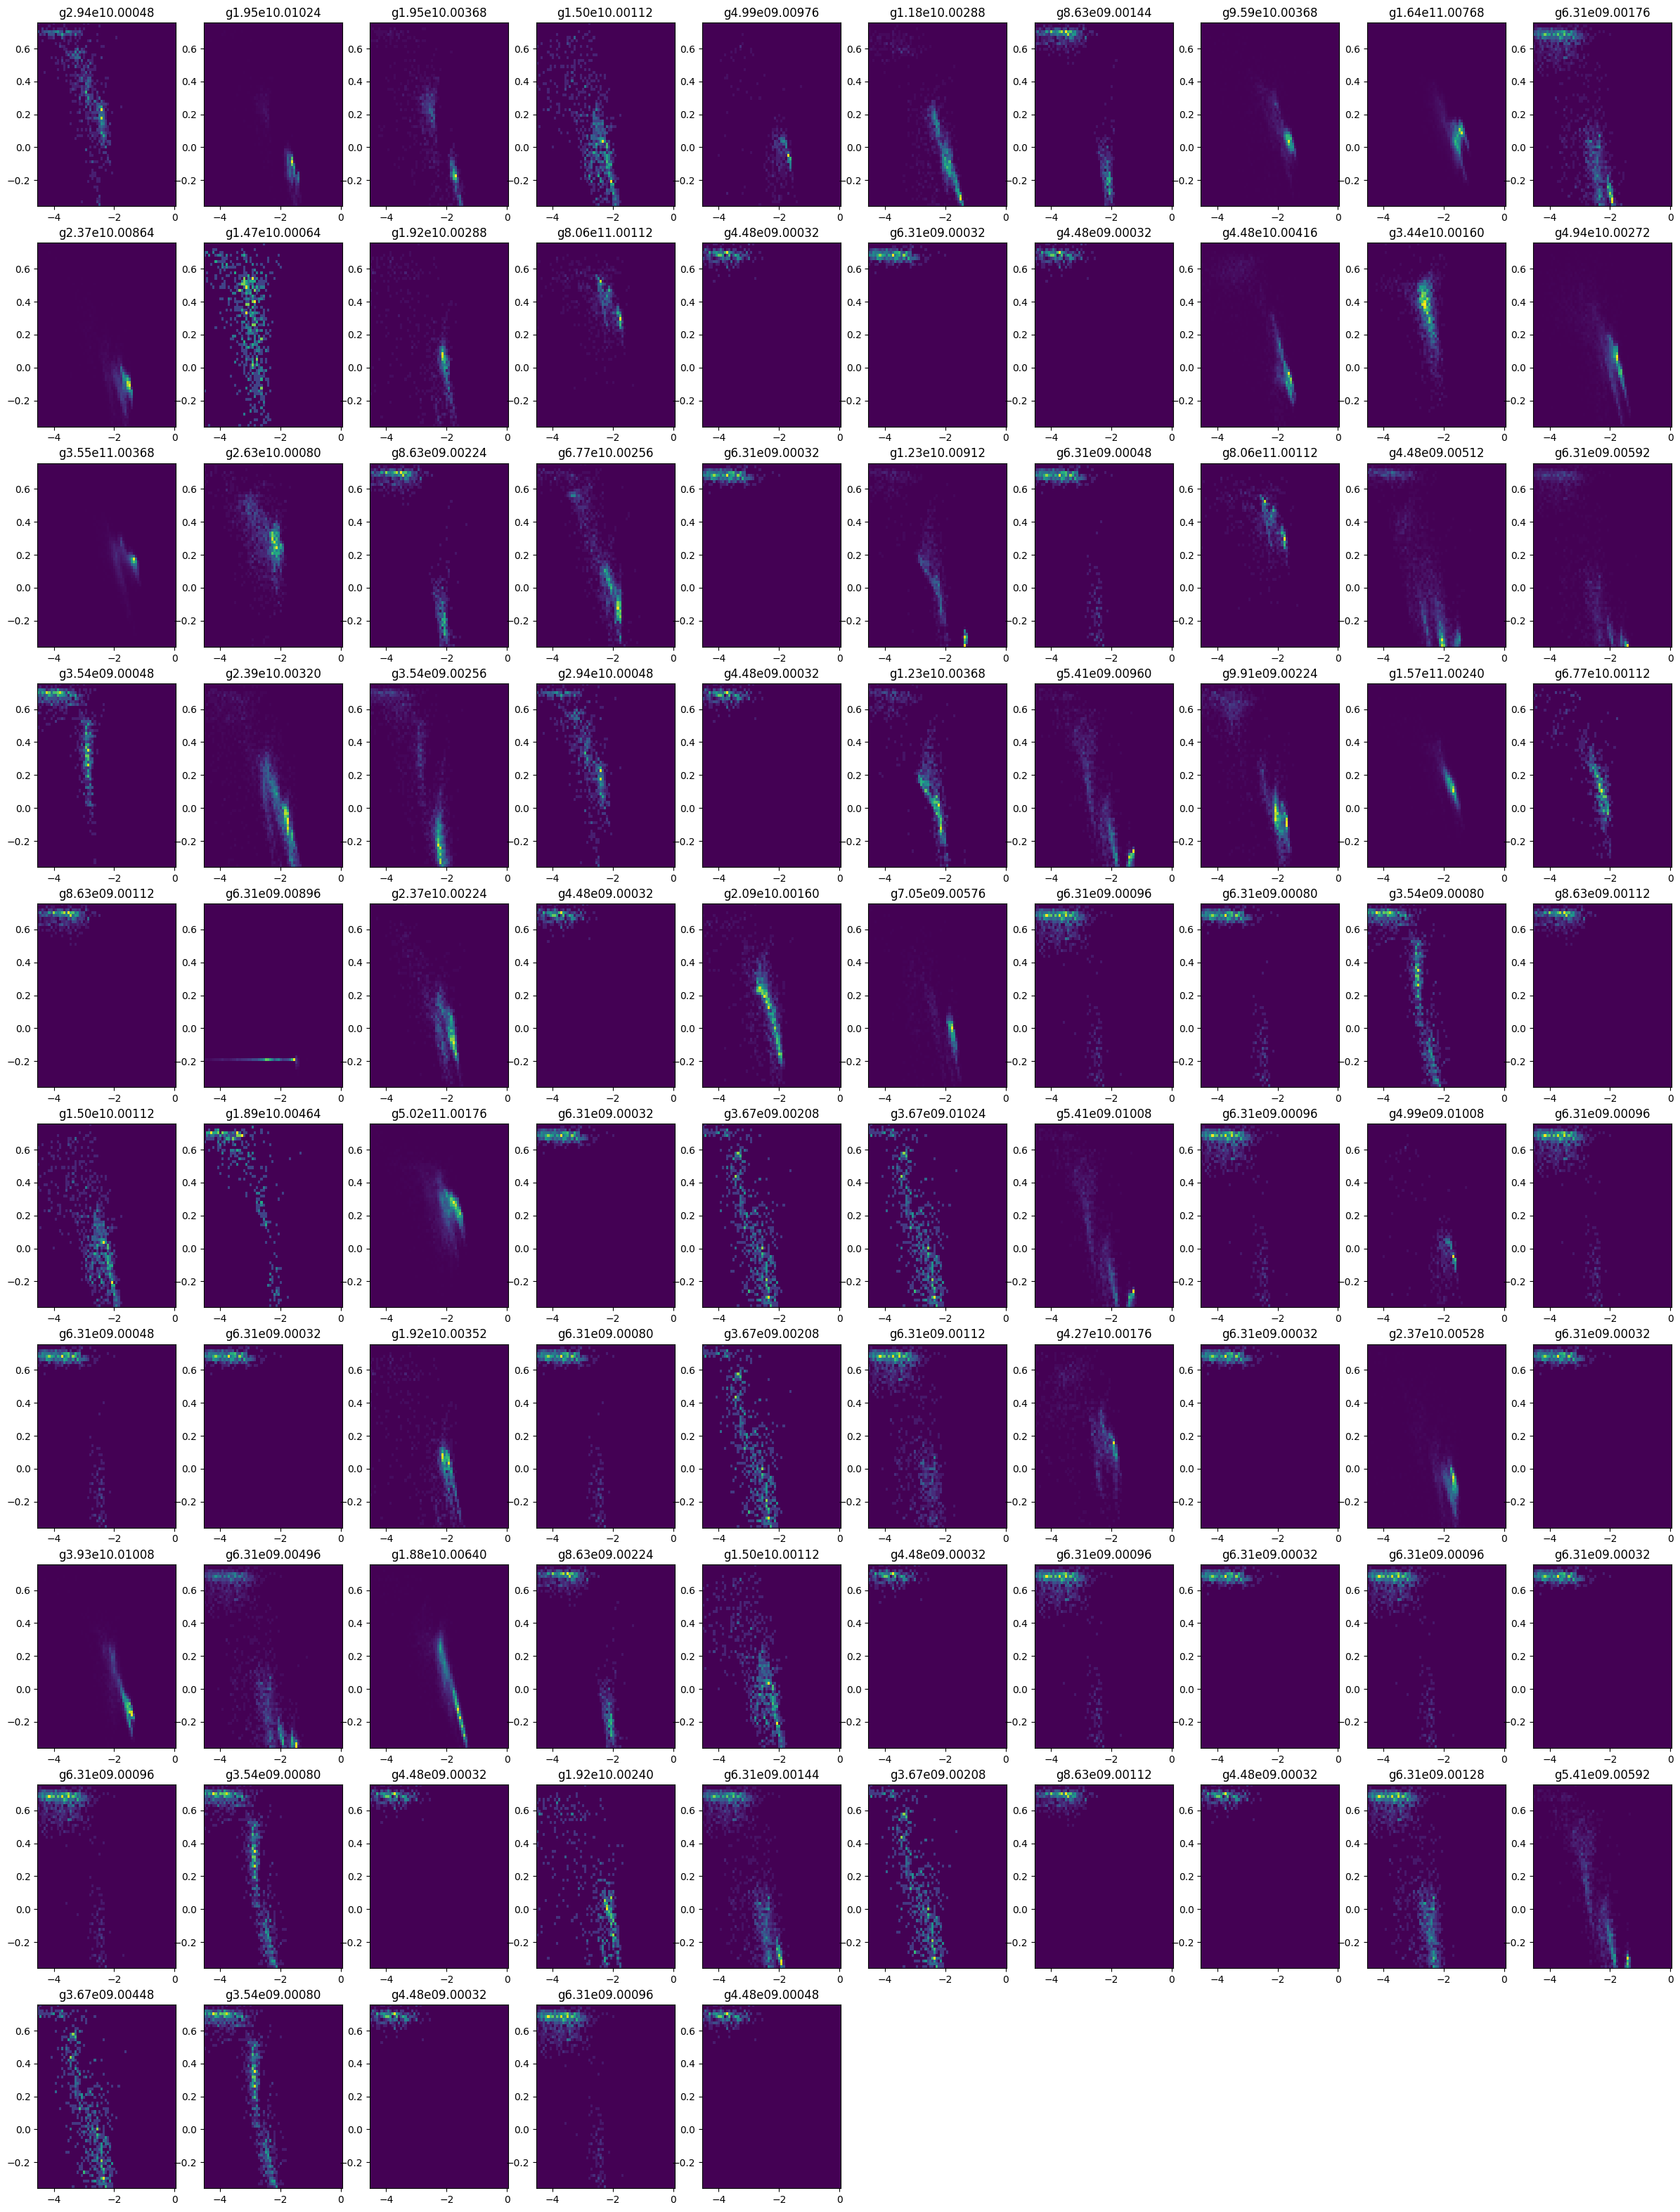

In [141]:
arr = np.array([data[data["star_log10mass"] == s]["Galaxy_name"].values[0]  for s in sim ])
fig = plt.figure(figsize=(30, 40))
min_feh, max_feh = data['feh'].min(), data['feh'].max()
min_ofe, max_ofe = data['ofe'].min(), data['ofe'].max()
for i, name in enumerate(arr):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{name}'+'.npz' )['observables'].T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe],aspect='auto' )
    ax.set_title(name)

## Create 50 halos

In [151]:
from multiprocessing import Pool

with Pool() as p:
    result = p.map(gen_real_halo, range(50) )

hist_list, sim_mass_list, samples = zip(*result)

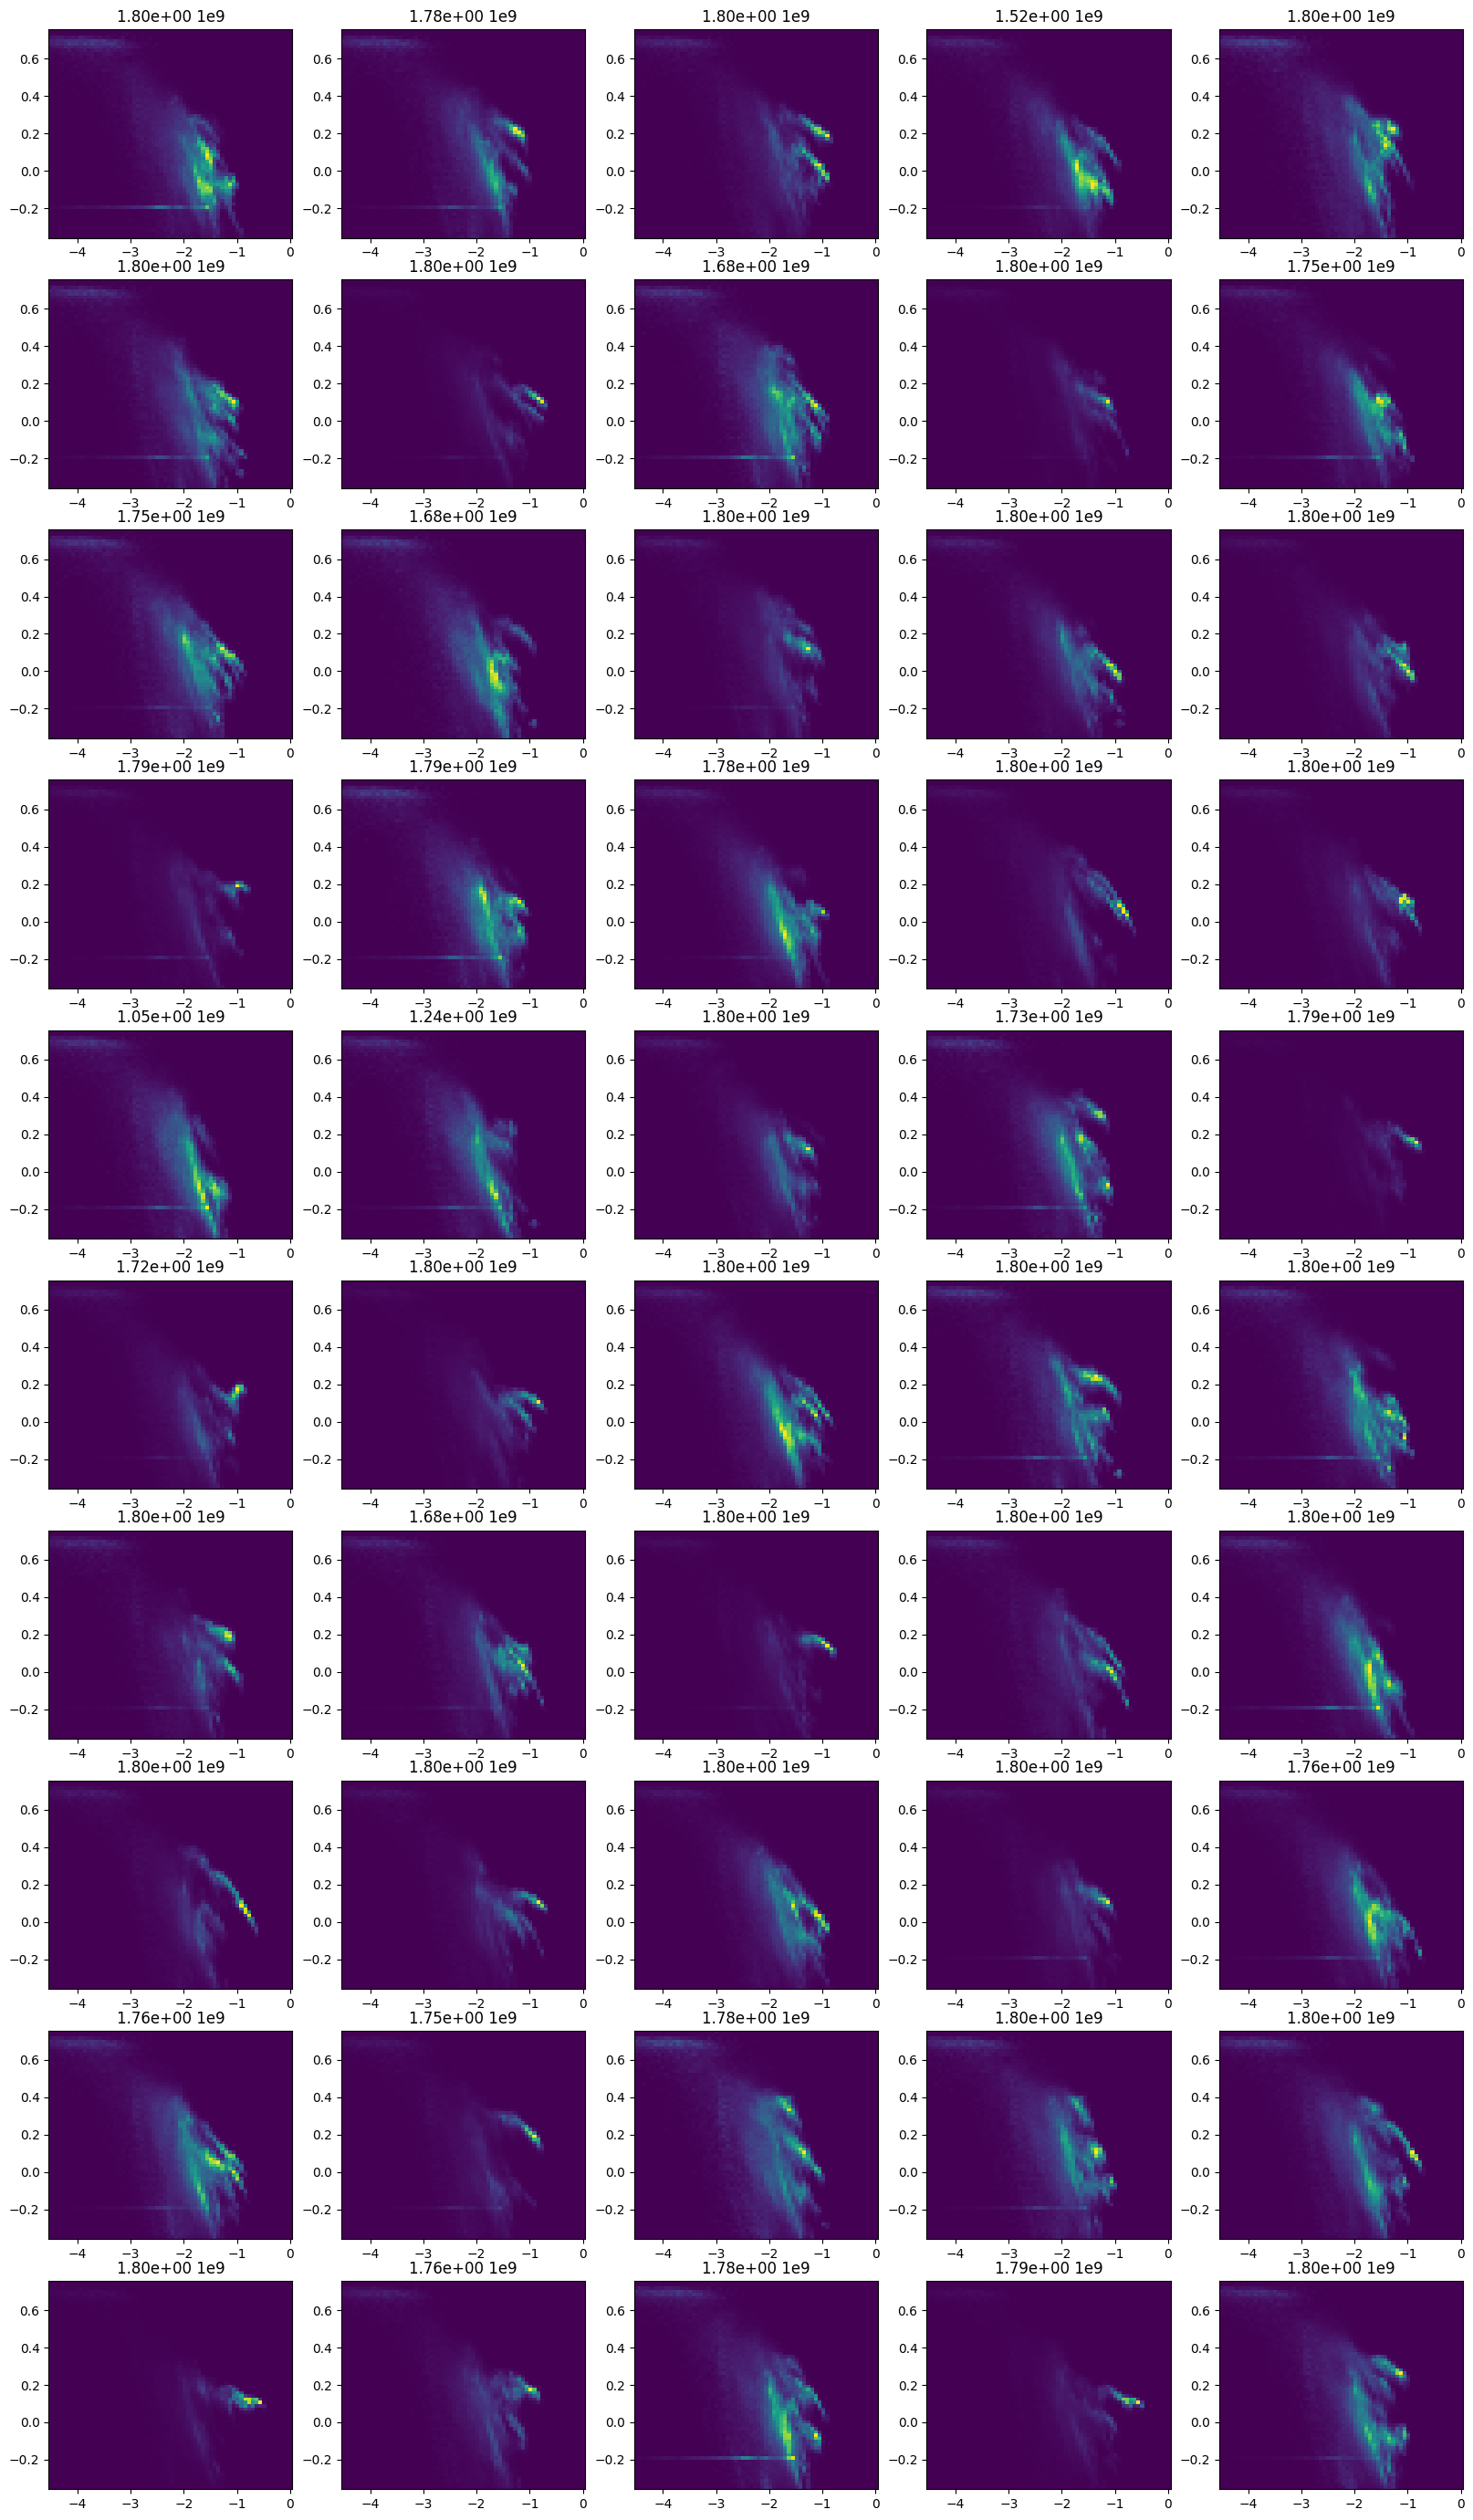

In [152]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(hist.T, origin='lower',extent=[min_feh, max_feh, min_ofe, max_ofe],aspect='auto' )
    ax.set_title(f'{np.sum(sim_mass_list[i])/1e9:.2e} 1e9')
    

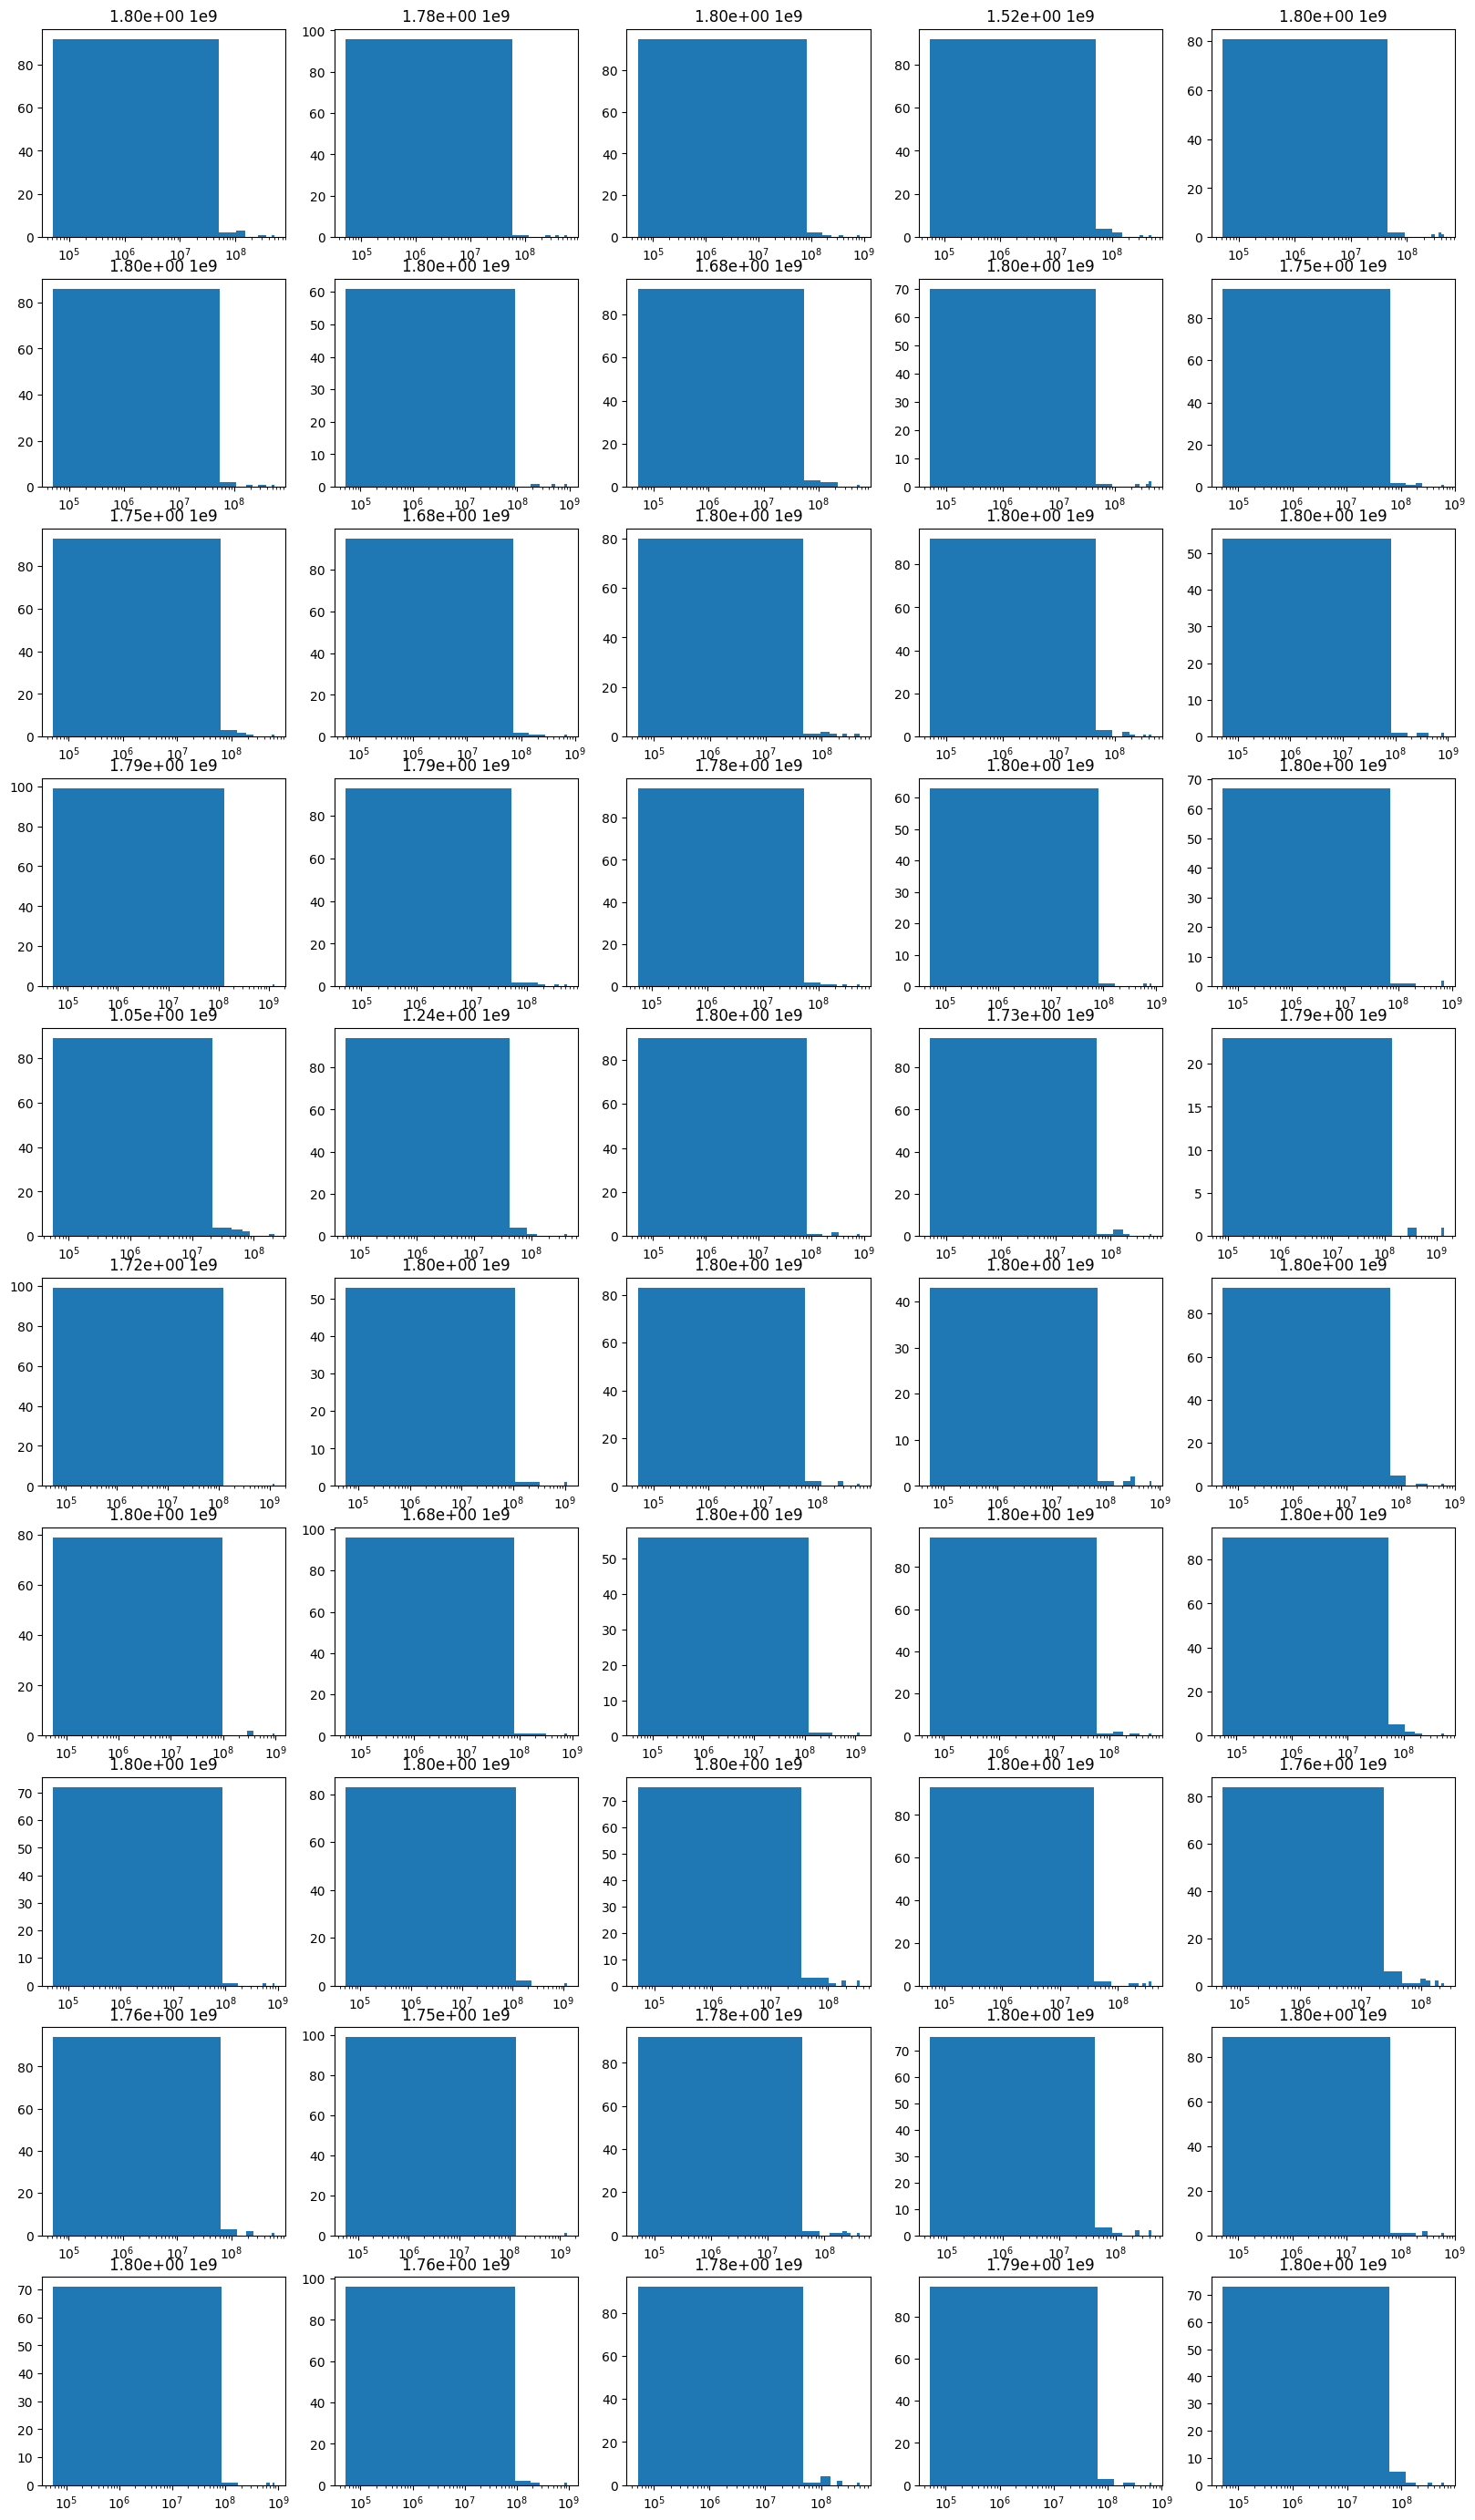

In [154]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.hist(sim_mass_list[i], )
    ax.set_title(f'{np.sum(sim_mass_list[i])/1e9:.2e} 1e9')
    ax.set_xscale('log')

## Realistic halo, sample, NN and then accreat with NN backward looking

In [7]:
mass_name = data[['star_log10mass', 'Galaxy_name']].drop_duplicates()
mass_name = mass_name[mass_name['star_log10mass']<1.4*1e9]

In [8]:
len(mass_name)

3778

In [5]:
def gen_real_halo(j, mass_nn, data):
    np.random.seed(j)
    
    N=3
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)
    M_tot = 1.8 * 1e9
    samples = []
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot > data_mass.max():
            analictical_sample = inverse_cdf(np.random.rand(1), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = mass_nn[indices[0]][0][0]
            if sample in samples:
                sample = mass_nn[indices[0]][1][0]
                if sample in samples:
                    sample = mass_nn[indices[0]][2][0]
                    samples.append(sample)
                else:
                    samples.append(sample)
            else:
                samples.append(sample)
            M_tot = M_tot - samples[-1]
        else:
            if M_tot < data_mass.min():
                break
            max_u = cdf(M_tot, alpha)
            analictical_sample = inverse_cdf(np.random.uniform(0, max_u), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = mass_nn[indices[0]][0][0]
            if sample in samples:
                sample = mass_nn[indices[0]][1][0]
                if sample in samples:
                    sample = mass_nn[indices[0]][2][0]
                    samples.append(sample)
                else:
                    samples.append(sample)
            else:
                samples.append(sample)
            M_tot = M_tot - samples[-1]
        iteration += 1 
        
    samples =  np.array(samples)
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{data[data["star_log10mass"] == s]["Galaxy_name"].values[0]}'+'.npz' )['observables']  for s in samples ])
    hist = np.sum( arr, axis=0)
    return hist, samples

In [8]:

mass_nn = data_mass.values.reshape(-1, 1)
with Pool(processes=cpu_count()) as p:
    result = p.starmap(gen_real_halo, [[j, mass_nn, data] for j in range(500)]   )

hist_list, sim_mass_list = zip(*result)

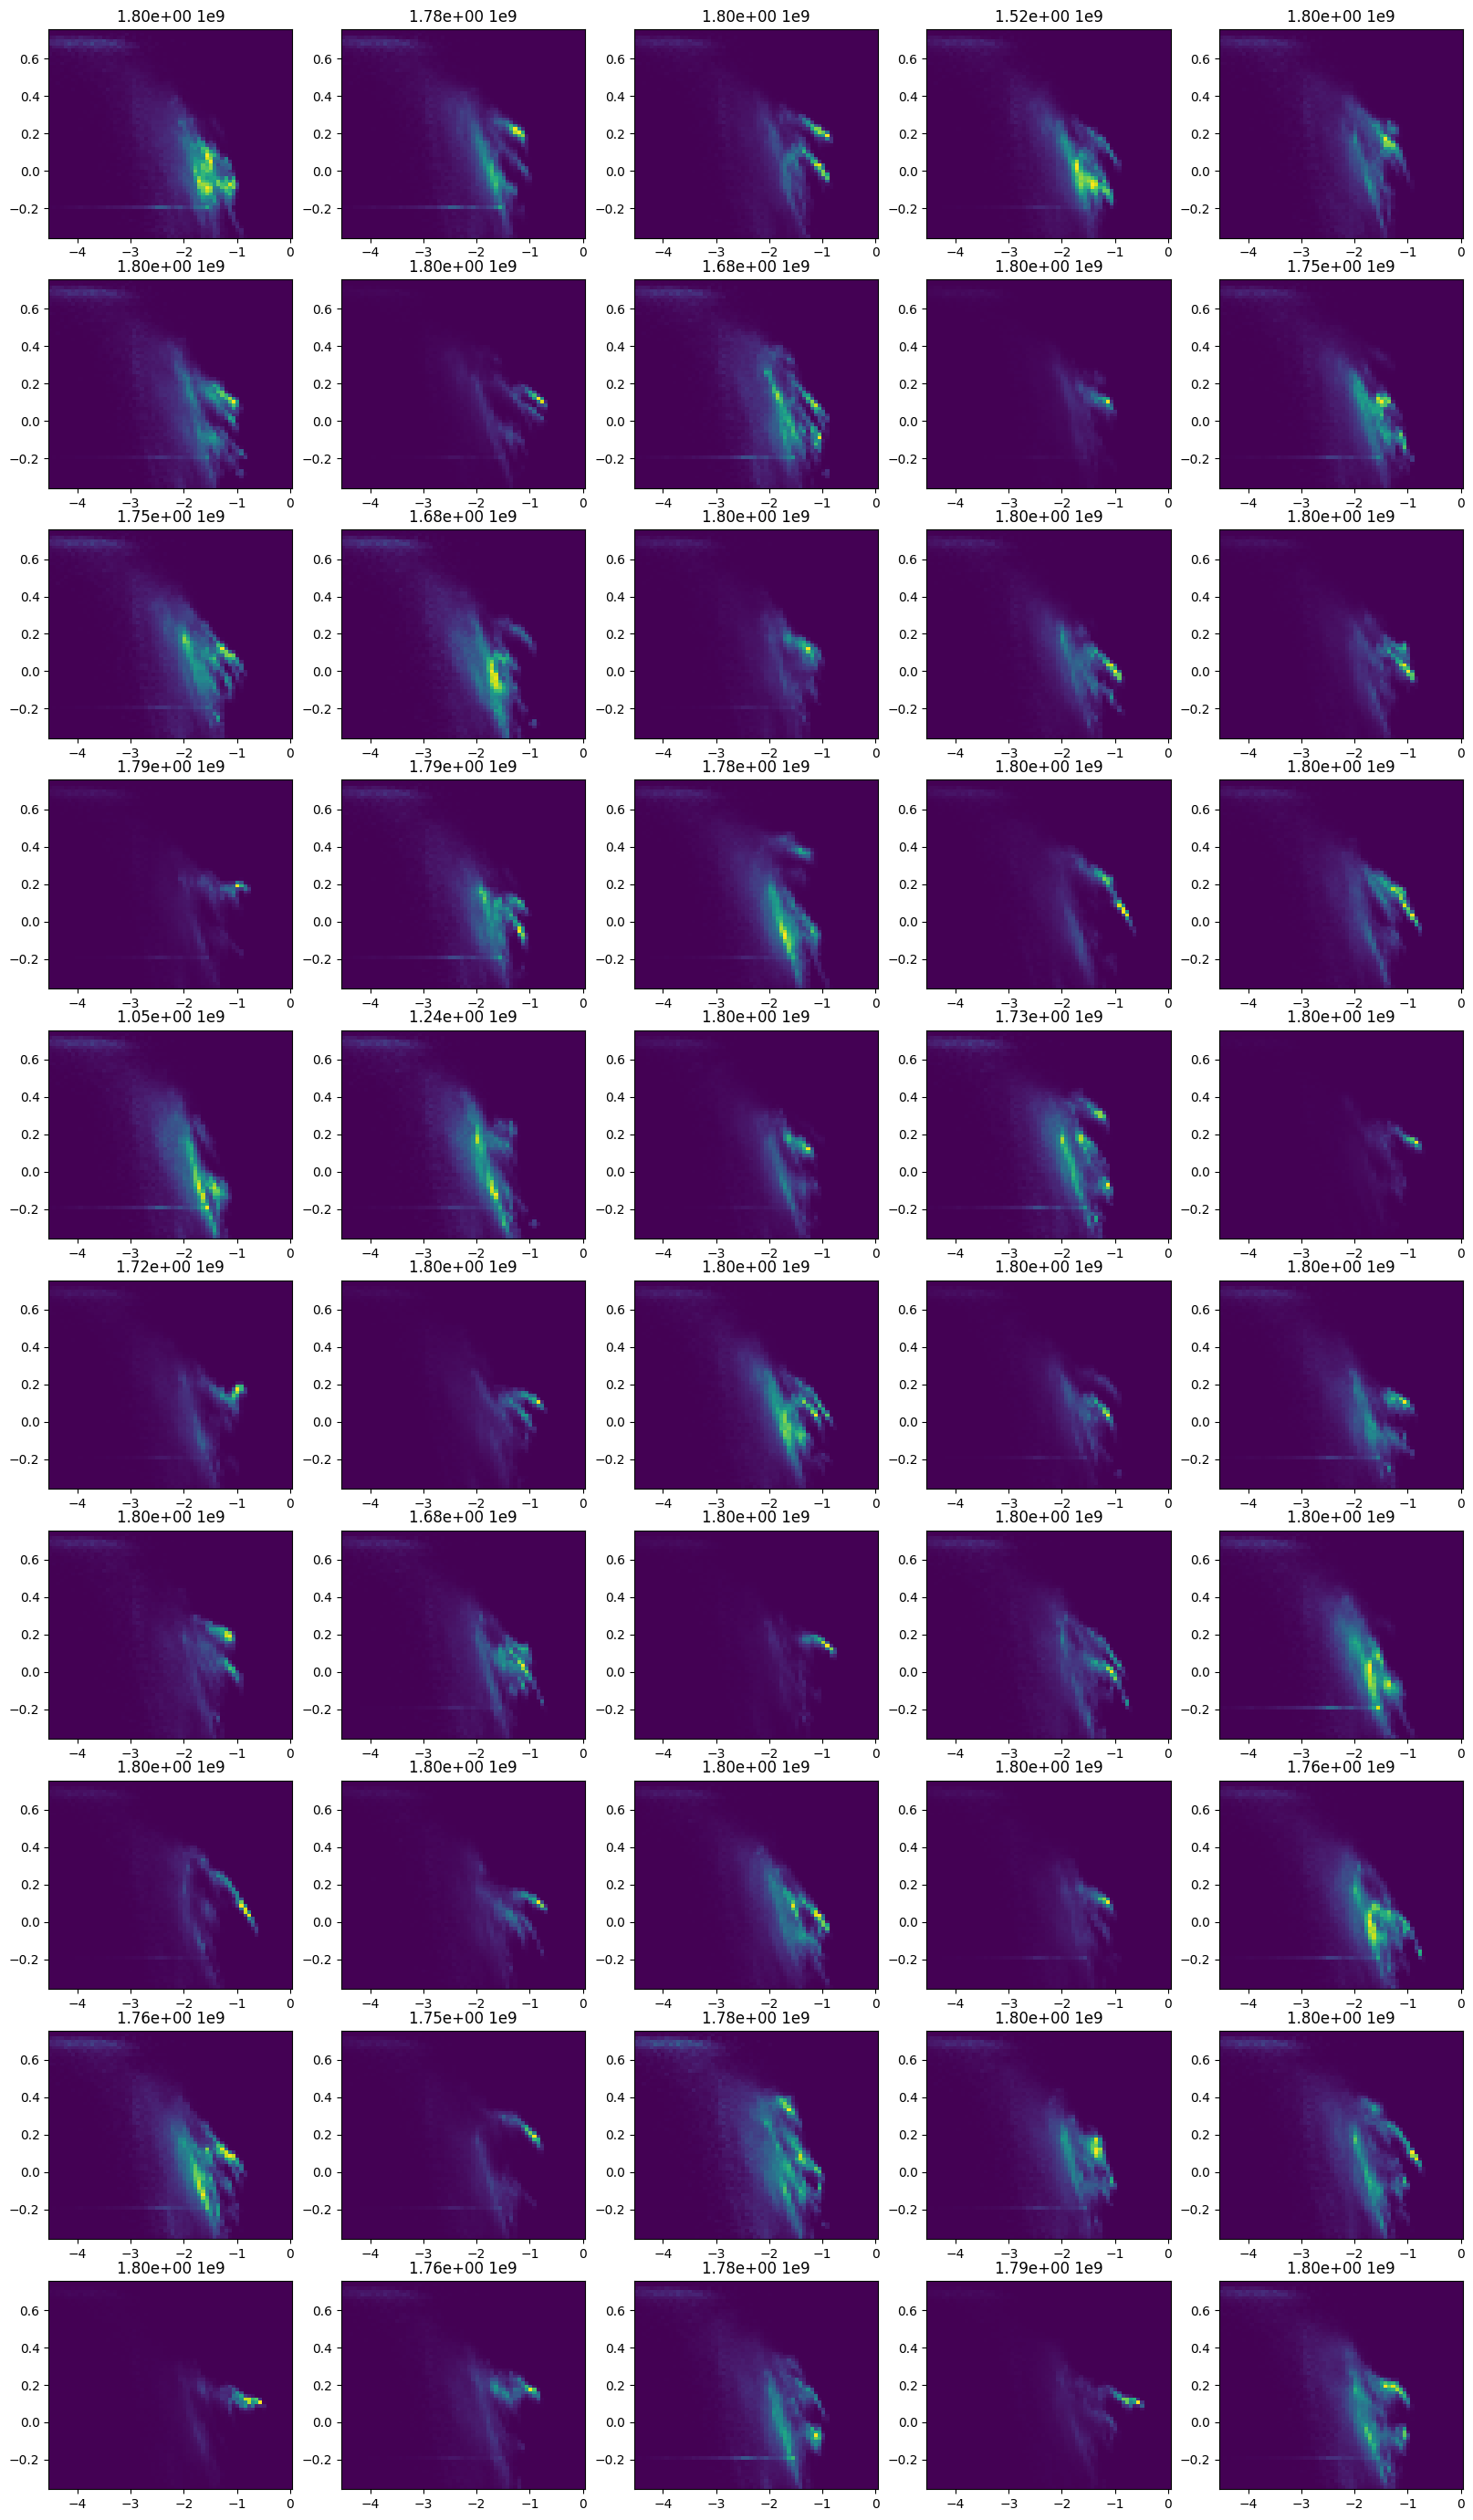

In [191]:
# fig, axs = plt.subplots(10, 5, figsize=(20, 30))
fig = plt.figure(figsize=(20, 35))

# Plot the data
for i, hist in enumerate(hist_list):
    # ax = axs[i // 5, i % 5]
    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(hist.T, origin='lower',extent=[min_feh, max_feh, min_ofe, max_ofe],aspect='auto' )
    ax.set_title(f'{np.sum(sim_mass_list[i])/1e9:.2e} 1e9')
    

In [35]:
def gen_real_halo(j, mass_nn, galaxy_name):
    np.random.seed(j)
    
    N=3
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='ball_tree').fit(mass_nn)
    M_tot = 1.8 * 1e9
    samples = []
    iteration = 0
    while iteration < 100: #number of max halos to be sampled
        if M_tot > mass_nn.max():
            analictical_sample = inverse_cdf(np.random.rand(1), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = galaxy_name[indices[0]][0][0]
            mass_sample = mass_nn[indices[0]][0][0]
            if sample in samples:
                sample = galaxy_name[indices[0]][1][0]
                mass_sample = mass_nn[indices[0]][1][0]
                if sample in samples:
                    sample = galaxy_name[indices[0]][2][0]
                    mass_sample = mass_nn[indices[0]][2][0]
                    samples.append(sample)
                else:
                    samples.append(sample)
            else:
                samples.append(sample)
            M_tot = M_tot - mass_sample
        else:
            if M_tot < mass_nn.min():
                break
            max_u = cdf(M_tot, alpha)
            analictical_sample = inverse_cdf(np.random.uniform(0, max_u), alpha, ).reshape(-1, 1)
            distances, indices = nbrs.kneighbors(analictical_sample)
            sample = galaxy_name[indices[0]][0][0]
            mass_sample = mass_nn[indices[0]][0][0]
            if sample in samples:
                sample = galaxy_name[indices[0]][1][0]
                mass_sample = mass_nn[indices[0]][1][0]
                if sample in samples:
                    sample = galaxy_name[indices[0]][2][0]
                    mass_sample = mass_nn[indices[0]][2][0]
                    samples.append(sample)
                else:
                    samples.append(sample)
            else:
                samples.append(sample)
            M_tot = M_tot - mass_sample
        iteration += 1 
        
    samples =  np.array(samples)
    arr = np.array([np.load('/export/data/vgiusepp/data/full_dataframe/histogram_data/'+f'{s}'+'.npz' )['observables']  for s in samples ])
    hist = np.expand_dims(np.log10(np.sum( arr, axis=0) + 1e-6 +1), axis=0)
    # hist = np.expand_dims(np.log10(arr + 1e-6 +1), axis=0)
    return hist, samples

In [36]:
mass_name = data[['star_log10mass', 'Galaxy_name']].drop_duplicates()
mass_name = mass_name[mass_name['star_log10mass']<1.4*1e9]

In [37]:
mass_nn = mass_name['star_log10mass'].values.reshape(-1, 1)
galaxy_name = mass_name['Galaxy_name'].values.reshape(-1, 1)
with Pool(processes=cpu_count()) as p:
    result = p.starmap(gen_real_halo, [[j, mass_nn, galaxy_name] for j in range(100_000)]   )

hist_list, sim_mass_list = zip(*result)

In [47]:
np.array([s for s in sim_mass_list])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100000,) + inhomogeneous part.

(array([2.7000e+01, 2.2900e+02, 1.0450e+03, 2.2870e+03, 4.0480e+03,
        6.9130e+03, 8.0350e+03, 1.0675e+04, 1.0445e+04, 5.6296e+04]),
 array([  6. ,  15.4,  24.8,  34.2,  43.6,  53. ,  62.4,  71.8,  81.2,
         90.6, 100. ]),
 <BarContainer object of 10 artists>)

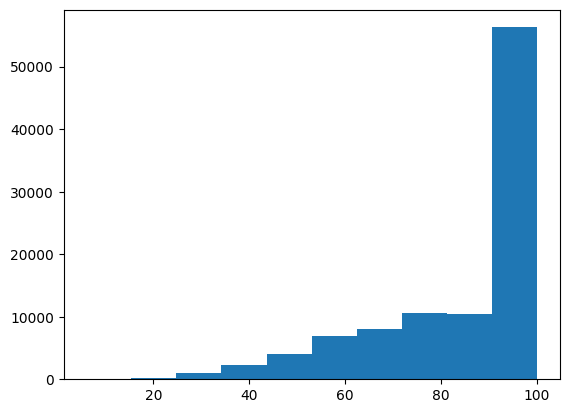

In [51]:
lenght = [len(s) for s in sim_mass_list]
plt.hist(lenght)